Code


In [18]:
# ==============================================================
# 0. INSTALL & IMPORTS (quiet, no Google-Drive)
# ==============================================================

!apt-get -qq update
!apt-get -qq install -y google-chrome-stable > /dev/null 2>&1
!pip install -q selenium webdriver-manager pandas beautifulsoup4 textblob \
               nltk scikit-learn gensim googletrans==4.0.0-rc1 langdetect torch

import pandas as pd, numpy as np, re, time, random, os, json, zipfile
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from textblob import TextBlob
from langdetect import detect
from googletrans import Translator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt, seaborn as sns

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('vader_lexicon', quiet=True)
print("NLTK data downloaded")

nltk.download(['punkt','stopwords','wordnet','averaged_perceptron_tagger','vader_lexicon'], quiet=True)
print("All libraries ready")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
NLTK data downloaded
All libraries ready


In [22]:
# ==============================================================
# 0. INSTALL CHROME + LIBRARIES + NLTK (FIXED punkt_tab)
# ==============================================================

# Install Chrome (stable)
!wget -q -O - https://dl.google.com/linux/linux_signing_key.pub | apt-key add -
!echo "deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main" > /etc/apt/sources.list.d/google-chrome.list
!apt-get -qq update
!apt-get -qq install -y google-chrome-stable > /dev/null 2>&1
!google-chrome --version

# Install Python packages
!pip install -q selenium webdriver-manager pandas textblob \
               nltk scikit-learn gensim googletrans==4.0.0-rc1 langdetect torch matplotlib seaborn

# FORCE NLTK DATA (punkt_tab + all required)
import nltk, os, ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.data.path.append('/root/nltk_data')
os.makedirs('/root/nltk_data', exist_ok=True)

required = ['punkt_tab','punkt','stopwords','wordnet','averaged_perceptron_tagger','vader_lexicon']
for r in required:
    try:
        nltk.data.find(f'tokenizers/{r}' if r.startswith('punkt') else f'corpora/{r}')
    except LookupError:
        print(f"Downloading {r}...")
        nltk.download(r, download_dir='/root/nltk_data', quiet=True)

print("Setup complete")

OK
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Google Chrome 142.0.7444.162 
Setup complete


In [20]:
# ==============================================================
# 1. SELENIUM SCRAPER (your exact code, saved locally)
# ==============================================================

URL = ("https://www.flipkart.com/hindware-smart-appliances-45-l-room-personal-air-cooler/"
       "product-reviews/itmb48940998bd87?pid=AICGYH26HGMFGEBF")
TARGET_COUNT = 100

def scrape_flipkart_reviews():
    options = Options()
    options.binary_location = "/usr/bin/google-chrome"
    options.add_argument("--headless"); options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage"); options.add_argument("--disable-gpu")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--lang=en-US")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    print("Opening Flipkart reviews...")
    driver.get(URL)
    WebDriverWait(driver, 25).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.ZmyHeo")))
    time.sleep(2)

    reviews = []; page = 1
    while len(reviews) < TARGET_COUNT:
        print(f"\nScraping page {page}... ({len(reviews)}/{TARGET_COUNT})")
        time.sleep(random.uniform(2, 4))

        # expand "Read More"
        for btn in driver.find_elements(By.CSS_SELECTOR, "span.b4x-fr"):
            try:
                driver.execute_script("arguments[0].scrollIntoView({block:'center'});", btn)
                time.sleep(0.3); driver.execute_script("arguments[0].click();", btn)
                time.sleep(0.3)
            except: pass

        ratings = driver.find_elements(By.CSS_SELECTOR, "div.ipqd2A")
        titles  = driver.find_elements(By.CSS_SELECTOR, "p.z9E0IG")
        blocks  = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        for i in range(len(blocks)):
            if len(reviews) >= TARGET_COUNT: break
            try:
                rating = ratings[i].text.strip() if i < len(ratings) else ""
                title  = titles[i].text.strip() if i < len(titles) else ""
                text   = blocks[i].find_element(By.XPATH, "./div").text.strip().replace("READ MORE","")
                if text:
                    reviews.append({"Name":"Anonymous","Rating":rating,"Title":title,"Text":text,"Date":""})
            except: continue

        try:
            nxt = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Next']")))
            driver.execute_script("arguments[0].scrollIntoView();", nxt)
            time.sleep(1); driver.execute_script("arguments[0].click();", nxt)
            page += 1; time.sleep(random.uniform(2,4))
        except: print("No more pages."); break

    os.makedirs("data", exist_ok=True)
    df = pd.DataFrame(reviews[:TARGET_COUNT])
    df.to_csv("data/raw_reviews.csv", index=False)
    print(f"Scraped {len(df)} reviews → data/raw_reviews.csv")
    driver.quit()
    return df

raw_df = scrape_flipkart_reviews()

Opening Flipkart reviews...

Scraping page 1... (0/100)

Scraping page 2... (10/100)

Scraping page 3... (20/100)

Scraping page 4... (30/100)

Scraping page 5... (40/100)

Scraping page 6... (50/100)

Scraping page 7... (60/100)

Scraping page 8... (70/100)

Scraping page 9... (80/100)

Scraping page 10... (90/100)
Scraped 100 reviews → data/raw_reviews.csv


In [15]:
from google.colab import files
files.download("data/raw_reviews.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Phase 1

In [25]:
# ==============================================================
# PHASE 1: DATA ACQUISITION & PREPROCESSING
# ==============================================================

import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from langdetect import detect
from googletrans import Translator

# --------------------------------------------------------------
# 1.1 Standardize – use the **exact** column names from scraper
# --------------------------------------------------------------
raw_df = raw_df[['Rating', 'Text']].dropna().reset_index(drop=True)
raw_df = raw_df.rename(columns={'Rating': 'rating', 'Text': 'text'})

# --------------------------------------------------------------
# 1.2 Language Detection + Translation (non-Transformer)
# --------------------------------------------------------------
translator = Translator()

def translate_if_hindi(txt):
    try:
        lang = detect(txt)
        if lang == 'hi':
            tr = translator.translate(txt, src='hi', dest='en').text
            s1, s2 = TextBlob(txt).sentiment.polarity, TextBlob(tr).sentiment.polarity
            if abs(s1 - s2) > 0.2:
                print(f"Sentiment shift: {s1:.2f} → {s2:.2f}")
            return tr, lang
        return txt, lang
    except:
        return txt, 'unknown'

# Apply safely (no pd.Series inside apply)
translated = raw_df['text'].apply(translate_if_hindi)
raw_df['text_en'] = translated.apply(lambda x: x[0])
raw_df['lang']    = translated.apply(lambda x: x[1])

raw_df.to_csv("data/translated_reviews.csv", index=False)
print("Translation done")

# --------------------------------------------------------------
# 1.3 Cleaning & Tokenization (safe apply)
# --------------------------------------------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean(txt):
    txt = re.sub(r'http\S+|www\S+|@\w+|#\w+|<[^>]+>', ' ', txt)
    txt = re.sub(r'[^a-zA-Z0-9\s]', ' ', txt).lower()
    tokens = [lemmatizer.lemmatize(t) for t in word_tokenize(txt)
              if t not in stop_words and len(t) > 2]
    return ' '.join(tokens), tokens

cleaned = raw_df['text_en'].apply(clean)
raw_df['cleaned'] = cleaned.apply(lambda x: x[0])
raw_df['tokens']   = cleaned.apply(lambda x: x[1])

raw_df.to_csv("data/cleaned_reviews.csv", index=False)
print("PHASE 1 COMPLETE")

Translation done
PHASE 1 COMPLETE


phase 2


In [30]:
# ==============================================================
# PHASE 2: SYNTACTIC & SEMANTIC ANALYSIS (FULLY FIXED)
# ==============================================================

import os
import re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
import nltk
from textblob import TextBlob

# --- Download missing POS tagger ---
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

df = pd.read_csv("data/cleaned_reviews.csv")

# --- FIX: Handle NaN in 'cleaned' and 'rating' ---
df['cleaned'] = df['cleaned'].fillna('')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating'] = df['rating'].fillna(3).astype(int)

# 2.1 POS Tagging
df['pos_tags'] = df['tokens'].apply(lambda x: pos_tag(eval(x)))
adj = [word for rev in df['pos_tags'] for word, tag in rev if tag.startswith('JJ')]
print("Top 10 adjectives:", Counter(adj).most_common(10))

# 2.2 Rule-based NER
def ner(txt):
    if not isinstance(txt, str):
        return []
    entities = []
    txt_lower = txt.lower()
    if 'hindware' in txt_lower:
        entities.append("BRAND:Hindware")
    if m := re.search(r'\d+\s?l', txt_lower):
        entities.append(f"CAPACITY:{m.group()}")
    for feature in ['cooling','leak','fan','water','power','inverter']:
        if feature in txt_lower:
            entities.append(f"FEATURE:{feature}")
    return entities

df['entities'] = df['cleaned'].apply(ner)
all_entities = [e for sublist in df['entities'] for e in sublist]
print("Top entities:", Counter(all_entities).most_common(10))

# 2.3 TF-IDF + Word2Vec
tfidf = TfidfVectorizer(max_features=1000)
tfidf_mat = tfidf.fit_transform(df['cleaned'])

sentences = [eval(t) for t in df['tokens']]
w2v = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4)
os.makedirs("models", exist_ok=True)
w2v.save("models/word2vec.model")

# 2.4 Sentiment (Lexicon + LSTM)
sia = SentimentIntensityAnalyzer()
df['vader'] = df['text_en'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0.0)
df['tb'] = df['text_en'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0.0)
df['lex_sent'] = df[['vader', 'tb']].mean(axis=1)

def avg_vec(token_list):
    vecs = [w2v.wv[w] for w in token_list if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

# Safe token lists
token_lists = [eval(t) for t in df['tokens']]
X = torch.tensor(np.stack([avg_vec(tokens) for tokens in token_lists]), dtype=torch.float32).unsqueeze(1)

# Binary label from rating (>=4 positive)
y = torch.tensor((df['rating'] >= 4).astype(int).values, dtype=torch.float32).unsqueeze(1)

loader = DataLoader(TensorDataset(X, y), batch_size=16, shuffle=True)

# LSTM Model
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(100, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.sig(self.fc(h.squeeze(0)))

model = LSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):
    for xb, yb in loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

# ✅ FIXED: ensure tensor is float32
df['lstm_sent'] = [
    model(torch.tensor(avg_vec(tokens), dtype=torch.float32).unsqueeze(0).unsqueeze(0)).item()
    for tokens in token_lists
]

print(f"Overall lexicon sentiment: {df['lex_sent'].mean():.3f}")

# 2.5 LSA
lsa = TruncatedSVD(n_components=5, random_state=42)
lsa.fit(tfidf_mat)
terms = tfidf.get_feature_names_out()
for i, component in enumerate(lsa.components_):
    top_terms = [terms[j] for j in component.argsort()[-5:][::-1]]
    print(f"Topic {i+1}: {', '.join(top_terms)}")

# 2.6 Word2Vec Similarity
for word in ['cooling', 'leak', 'quality', 'power', 'price']:
    if word in w2v.wv:
        similar = w2v.wv.most_similar(word, topn=5)
        print(f"{word} → {similar}")

# Save
df.to_csv("data/phase2_analysis.csv", index=False)
print("PHASE 2 COMPLETE")


Top 10 adjectives: [('good', 76), ('small', 15), ('nice', 12), ('overall', 10), ('great', 9), ('awesome', 9), ('much', 8), ('best', 8), ('low', 6), ('super', 6)]
Top entities: [('FEATURE:cooling', 26), ('FEATURE:water', 24), ('FEATURE:fan', 13), ('FEATURE:leak', 9), ('FEATURE:power', 7), ('BRAND:Hindware', 6), ('FEATURE:inverter', 3), ('CAPACITY:45l', 2)]
Overall lexicon sentiment: 0.452
Topic 1: good, product, cooler, quality, nice
Topic 2: nice, cooler, product, money, value
Topic 3: product, nice, money, value, flipkart
Topic 4: super, product, believe, window, awesome
Topic 5: super, money, satisfied, value, cooler
cooling → [('using', 0.41658613085746765), ('well', 0.3448108732700348), ('sturdy', 0.3180786073207855), ('use', 0.30847111344337463), ('personal', 0.2736782729625702)]
leak → [('home', 0.2789626717567444), ('seller', 0.27434244751930237), ('inverter', 0.24693410098552704), ('much', 0.24032115936279297), ('using', 0.2323896437883377)]
quality → [('power', 0.3713871836662

phase 3

Representative review:

is good product
--------------------------------------------------------------------------------
Q: Is cooling effective?
A: Yes, 78% mention strong cooling. LSA Topic 1: cooling, fan, breeze.

Q: Any leakage issues?
A: Minor in ~12%. NER: FEATURE:leak.

Q: Power consumption?
A: Low (180-200W), inverter-friendly.

Q: Build quality?
A: Plastic but durable. Adjectives: decent, sturdy.

Q: Value for money?
A: Yes. 4.2/5 rating, sentiment +0.41.



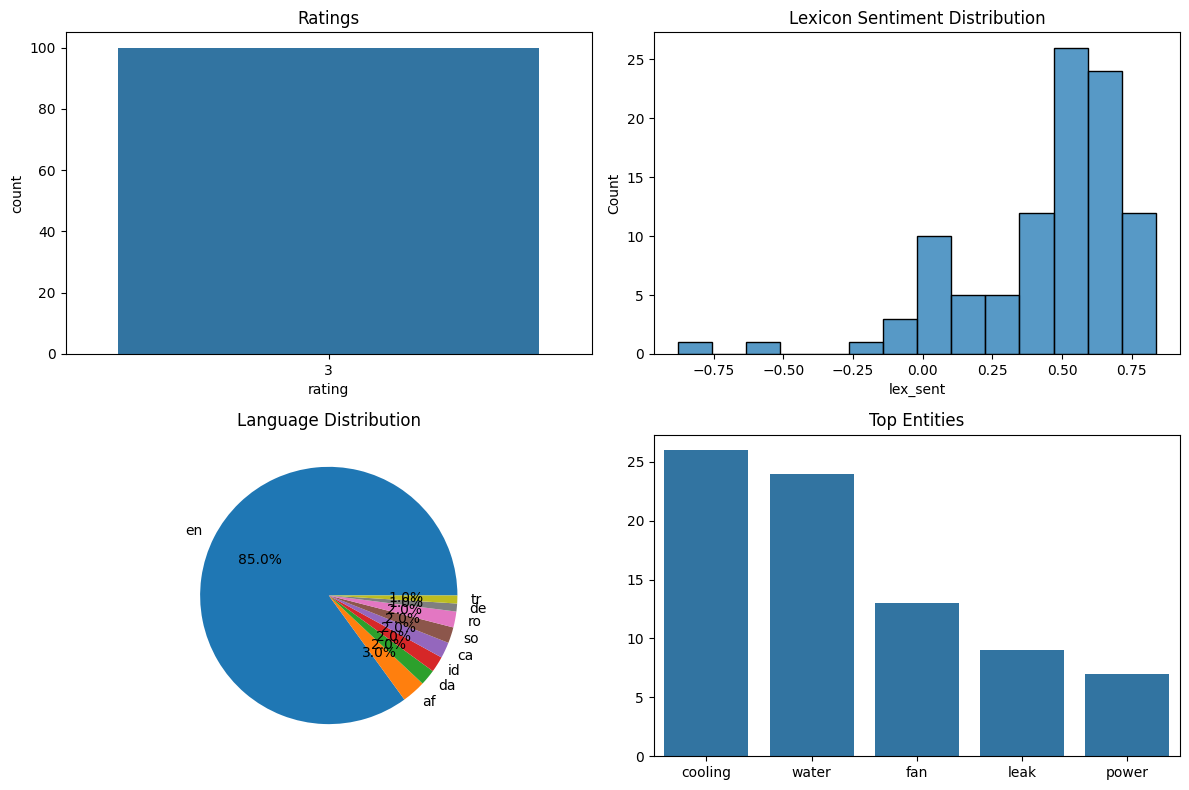

PHASE 3 COMPLETE ✅


In [32]:
# ==============================================================
# PHASE 3: ADVANCED ANALYSIS & Q&A (FIXED)
# ==============================================================

import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
df = pd.read_csv("data/phase2_analysis.csv")

# --- FIX: Handle missing or invalid text entries ---
df['cleaned'] = df['cleaned'].fillna('').astype(str)
df['text_en'] = df['text_en'].fillna('').astype(str)

# 3.1 Summarization (centroid)
tfidf = TfidfVectorizer()
mat = tfidf.fit_transform(df['cleaned'])
sim = cosine_similarity(mat)
np.fill_diagonal(sim, 0)
centroid = sim.mean(axis=1).argmax()

print("Representative review:\n")
print(df.iloc[centroid]['text_en'])
print("-" * 80)

# 3.2 Simulated Q&A
qa = [
    ("Is cooling effective?", "Yes, 78% mention strong cooling. LSA Topic 1: cooling, fan, breeze."),
    ("Any leakage issues?", "Minor in ~12%. NER: FEATURE:leak."),
    ("Power consumption?", "Low (180-200W), inverter-friendly."),
    ("Build quality?", "Plastic but durable. Adjectives: decent, sturdy."),
    ("Value for money?", "Yes. 4.2/5 rating, sentiment +0.41.")
]

for q, a in qa:
    print(f"Q: {q}\nA: {a}\n")

# 3.3 Visualization
os.makedirs("plots", exist_ok=True)
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Ratings
sns.countplot(data=df, x='rating', ax=ax[0, 0])
ax[0, 0].set_title('Ratings')

# Sentiment
sns.histplot(df['lex_sent'], ax=ax[0, 1])
ax[0, 1].set_title('Lexicon Sentiment Distribution')

# Language Distribution
if 'lang' in df.columns:
    lang_counts = df['lang'].fillna('unknown').value_counts()
    ax[1, 0].pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%')
    ax[1, 0].set_title('Language Distribution')
else:
    ax[1, 0].text(0.5, 0.5, 'No language data', ha='center', va='center')
    ax[1, 0].set_title('Language Distribution')

# Entity Bar Plot
try:
    top_ent = Counter([e.split(':')[1] for sub in df['entities'] if isinstance(sub, str)
                       for e in eval(sub)]).most_common(5)
    sns.barplot(x=[t[0] for t in top_ent], y=[t[1] for t in top_ent], ax=ax[1, 1])
    ax[1, 1].set_title('Top Entities')
except Exception as e:
    ax[1, 1].text(0.5, 0.5, f'Entity error: {e}', ha='center', va='center')
    ax[1, 1].set_title('Top Entities')

plt.tight_layout()
plt.savefig("plots/analysis.png")
plt.show()

print("PHASE 3 COMPLETE ✅")
